# Guide for twinpy/analysis/shear_analyzer.py

In [15]:
%aiida
%reload_ext autoreload
%autoreload 2

In [36]:
import os
import sys
from pprint import pprint
import numpy as np
import twinpy
from twinpy.interfaces.aiida import AiidaRelaxWorkChain, AiidaPhonopyWorkChain, AiidaShearWorkChain, AiidaTwinBoudnaryRelaxWorkChain
from twinpy.analysis.shear_analyzer import ShearAnalyzer, TwinBoundaryShearAnalyzer
from twinpy.plot.band_structure import (get_seekpath,
                                        get_labels_for_twin,
                                        get_band_paths_from_labels,
                                        get_labels_band_paths_from_seekpath,
                                        BandsPlot)

jupyter_dir = os.path.join(os.path.dirname(twinpy.__file__), '..', 'jupyter')
sys.path.append(os.path.join(jupyter_dir, 'site-packages'))
from jupyter_help import show_info

# shear_pk = 309999  # twinpy Mg_pv
shear_pk = 315857  # twinpy Ti_pv

twinboundary_pk = 186343  # twinpy
additional_relax_pks = [267977, 279276, 282215, 283951]   # twinpy
twinboundary_phonon_pk = 286877  # twinpy
twinboundary_shear_relax_pks = [326425, 297874, 297890, 297907, 297924]
twinboundary_shear_phonon_pks = [326490, 299318, 300184, 300580, 300760]
shear_strain_ratios = [0.00, 0.02, 0.04, 0.06, 0.08]

# class ShearAnalyzer

In [30]:
aiida_shear = AiidaShearWorkChain(load_node(shear_pk))
analyzer = aiida_shear.get_shear_analyzer()
show_info(analyzer, is_class=True)

====== START class information ======

# ---------
# docstring
# ---------

    Analize shear result.
    

# ----
# init
# ----

        Init.

        Args:
            shear_structure: ShearStructure class object.
            phonon_analyzers (list): List of PhononAnalyzer class object.

        Todo:
            Currently not supported the case the number of original_cells
            and input_cells changes because it is difficult to construct
            the relax cells in the original frame. But future fix this
            problem. One solution is to make attribute
            'self._original_primitive' which contains two atoms
            in the unit cell and original basis.
            Twinboundary shaer structure also use this class.
            If this is inconvenient, I have to create
            _BaseShaerAnalyzer, ShearAnalyzer TwinBoundaryShearAnalyzer
            classes separately.
        

# ---------------
# attribute names
# ---------------
['_relax_analyzers', '_p

## def get_shear_diffs

In [31]:
show_info(analyzer.get_shear_diffs)
print("# keys")
print(list(analyzer.get_shear_diffs().keys()))
print("")
print("# data")
pprint(analyzer.get_shear_diffs())

====== START method information ======

# ---------
# docstring
# ---------

        Get structure diffs between original relax and sheared relax cells
        IN ORIGINAL FRAME.
        

======= END method information =======


# keys
['lattice_diffs', 'scaled_posi_diffs', 'cart_posi_diffs', 'cart_norm_diffs']

# data
{'cart_norm_diffs': array([[0.        , 0.        ],
       [0.01507646, 0.02189647],
       [0.02908556, 0.04448814],
       [0.0418206 , 0.06788722],
       [0.0539469 , 0.09174354],
       [0.06642475, 0.11552427],
       [0.08039196, 0.13863193],
       [0.09676802, 0.16070287],
       [0.11650406, 0.18153068],
       [0.14103563, 0.20099605]]),
 'cart_posi_diffs': array([[[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       [[0.01265509, 0.00730642, 0.00371009],
        [0.00908033, 0.00524255, 0.01922288]],

       [[0.02440304, 0.0140891 , 0.00720822],
        [0.01906782, 0.01100883, 0.03865772]],

       [[0.035053  , 0.0

## def get_band_paths

In [32]:
show_info(analyzer.get_band_paths)
cell = analyzer.phonon_analyzers[0].primitive_cell
skp = get_seekpath(cell)
print("# You have to determine band paths for first cell.")
print("")
print("# twin labels")
pprint(get_labels_for_twin())
print("")
print("# seekpath output")
print("### path")
pprint(skp['path'])
print("")
print("### point coords")
pprint(skp['point_coords'])

# labels = ['GAMMA', 'M_2', 'L_2', 'A', '', 'GAMMA', 'K_2']
labels = ['GAMMA', 'M_1', 'L_1', 'A', '', 'GAMMA', 'K_1']
fixed_labels, band_paths = get_band_paths_from_labels(
                               labels=labels,
                               labels_qpoints=get_labels_for_twin())
print("")
print("Example:")
print("# labels")
print(labels)
print("")
print("# fixed labels")
print(fixed_labels)
print("")
print("# fixed labels, band_paths")
pprint(band_paths)

====== START method information ======

# ---------
# docstring
# ---------

        Get band paths for all shear cells from band paths for first cell.

        Args:
            base_band_paths (np.array): Path connections for first
                                             primitive standardized structure.

        Examples:
            >>> base_band_paths = [[[  0, 0, 0.5],
                                    [  0, 0, 0  ]],
                                   [[0.5, 0,   0],
                                    [0.5, 0, 0.5],
                                    [  0, 0, 0.5]]]

        Note:
            Get path_connections for each shear structure considering
            structure body rotation.
        

======= END method information =======


# You have to determine band paths for first cell.

# twin labels
{'A': [0, 0, 0.5],
 'GAMMA': [0, 0, 0],
 'H_1': [0.3333333333333333, 0.3333333333333333, 0.5],
 'H_2': [-0.3333333333333333, 0.6666666666666666, 0.5],
 'K_1': [0.3333333333

## def get_band_structures

====== START method information ======

# ---------
# docstring
# ---------

        Get BandStructure objects.

        Args:
            base_band_paths (np.array): Path connections for first
                                             primitive standardized structure.
            labels (list): Band labels for first band paths.
            npoints (int): The number of qpoints along the band path.
            with_eigenvectors (bool): If True, compute eigenvectors.

        Notes:
            Reciprocal lattices for each structure are set automatically.
            For more detail, see 'get_band_qpoints_and_path_connections'
            in phonopy.phonon.band_structure.
        

======= END method information =======




(<Figure size 576x432 with 2 Axes>,
  <matplotlib.axes._axes.Axes at 0x7f3400130f50>])

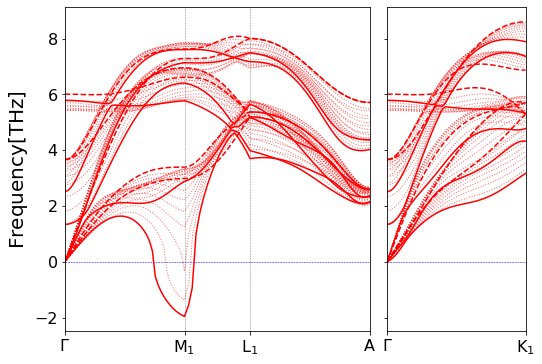

In [33]:
show_info(analyzer.get_band_structures)
band_structures = analyzer.get_band_structures(
    base_band_paths=band_paths,
    labels=fixed_labels,
    npoints=51,
    with_eigenvectors=False)
BandsPlot(band_structures).plot_band_structures()

# class TwinBoundaryShearAnalyzer

In [37]:
aiida_twinboundary_relax = AiidaTwinBoudnaryRelaxWorkChain(load_node(twinboundary_pk))
twinboundary_analyzer = aiida_twinboundary_relax.get_twinboundary_analyzer(
                            twinboundary_phonon_pk=twinboundary_phonon_pk,
                            additional_relax_pks=additional_relax_pks)

original_cells = []
for ratio in shear_strain_ratios:
    original_cell = twinboundary_analyzer.get_shear_cell(
        shear_strain_ratio=ratio,
        is_standardize=False)
    original_cells.append(original_cell)
    
phonon_analyzers = []
for i in range(len(original_cells)):
    aiida_relax = AiidaRelaxWorkChain(load_node(twinboundary_shear_relax_pks[i]))
    relax_analyzer = aiida_relax.get_relax_analyzer(original_cell=original_cells[i])
    aiida_phonon = AiidaPhonopyWorkChain(load_node(twinboundary_shear_phonon_pks[i]))
    phonon_analyzer = aiida_phonon.get_phonon_analyzer(relax_analyzer=relax_analyzer)
    phonon_analyzers.append(phonon_analyzer)

twinboundary_shear_analyzer = \
    twinboundary_analyzer.get_twinboundary_shear_analyzer(
        shear_phonon_analyzers=phonon_analyzers,
        shear_strain_ratios=shear_strain_ratios)

show_info(twinboundary_shear_analyzer, is_class=True)

====== START class information ======

# ---------
# docstring
# ---------

    Analize twinboundary shear result.
    

# ----
# init
# ----

        Init.

        Args:
            phonon_analyzers (list): List of PhononAnalyzer class object.
        

# ---------------
# attribute names
# ---------------
['_relax_analyzers', '_phonon_analyzers', '_shear_strain_ratios']

# ------
# values
# ------
{'_phonon_analyzers': [<twinpy.analysis.phonon_analyzer.PhononAnalyzer object at 0x7f33ffff0750>,
 '_relax_analyzers': [<twinpy.analysis.relax_analyzer.RelaxAnalyzer object at 0x7f33fd5440d0>,
 '_shear_strain_ratios': [0.0, 0.02, 0.04, 0.06, 0.08]}

======= END class information =======




## def get_atomic_environment

In [63]:
show_info(twinboundary_shear_analyzer.get_atomic_environment)
envs = twinboundary_shear_analyzer.get_atomic_environment()
print("# data num")
print(len(envs))
print("")
print("# first data")
pprint(envs[2][0])

====== START method information ======

# ---------
# docstring
# ---------

        Get plane coords from lower plane to upper plane.
        Return list of z coordinates of original cell frame.
        Plane coordinates (z coordinates) are fractional.
        

======= END method information =======


[ 0.          1.89710717  3.74827671  5.63493933  7.4965231   9.37212186
 11.24481651 13.12041526 14.98199903 16.86866166 18.71983119 20.61693836
 22.51404553 24.36521507 26.25187769 28.11346146 29.98906022 31.86175487
 33.73735362 35.59893739 37.48560002 39.33676955]
[ 0.7951914   2.86425702  4.65709629  6.56654847  8.43340317 10.30846918
 12.18353519 14.05038989 15.95984207 17.75268134 19.82174697 21.41414238
 23.47154975 25.28196867 27.18157337 29.0509287  30.92540754 32.79988638
 34.66924171 36.56884641 38.37926533 40.4366727 ]
[ 0.80119299  2.86903129  4.65249521  6.56750984  8.43291146 10.30846918
 12.18402691 14.04942852 15.96444315 17.74790707 19.81574537 21.42235411
 23.4678034

In [66]:
for relax_analyzer in twinboundary_shear_analyzer.relax_analyzers:
    pprint(relax_analyzer.final_cell_in_original_frame[1])

array([[0.5       , 0.19089084, 0.        ],
       [0.5       , 0.77502203, 0.        ],
       [0.5       , 0.67111932, 0.09688476],
       [0.5       , 0.25727972, 0.08492093],
       [0.        , 0.95088343, 0.05376225],
       [0.        , 0.49608494, 0.03825467],
       [0.5       , 0.13977765, 0.18921683],
       [0.5       , 0.72681942, 0.17439308],
       [0.        , 0.40807037, 0.14408109],
       [0.        , 0.98973005, 0.12923492],
       [0.5       , 0.60749996, 0.28013353],
       [0.5       , 0.19455507, 0.26528288],
       [0.        , 0.87372219, 0.23471712],
       [0.        , 0.4607773 , 0.21986647],
       [0.5       , 0.07854721, 0.37076508],
       [0.5       , 0.66020689, 0.35591891],
       [0.        , 0.34145784, 0.32560692],
       [0.        , 0.92849961, 0.31078317],
       [0.5       , 0.57219232, 0.46174533],
       [0.5       , 0.11739383, 0.44623775],
       [0.        , 0.81099754, 0.41507907],
       [0.        , 0.39715794, 0.40311524],
       [0.

## def plot_plane_diff

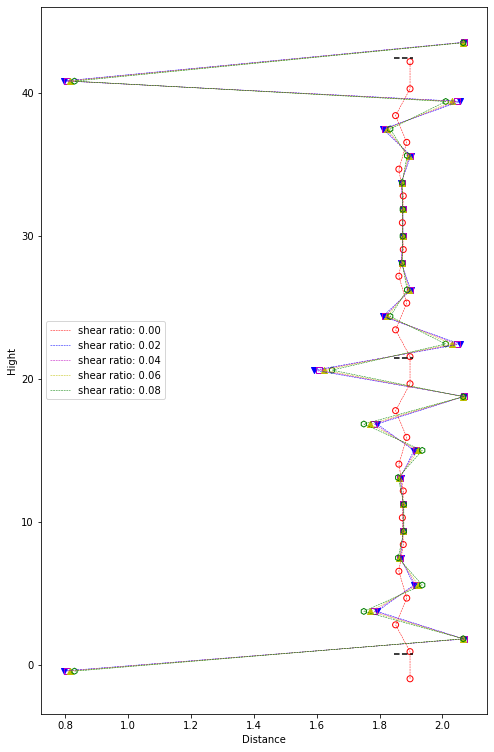

In [39]:
fig = twinboundary_shear_analyzer.plot_plane_diff()

## def plot_angle_diff

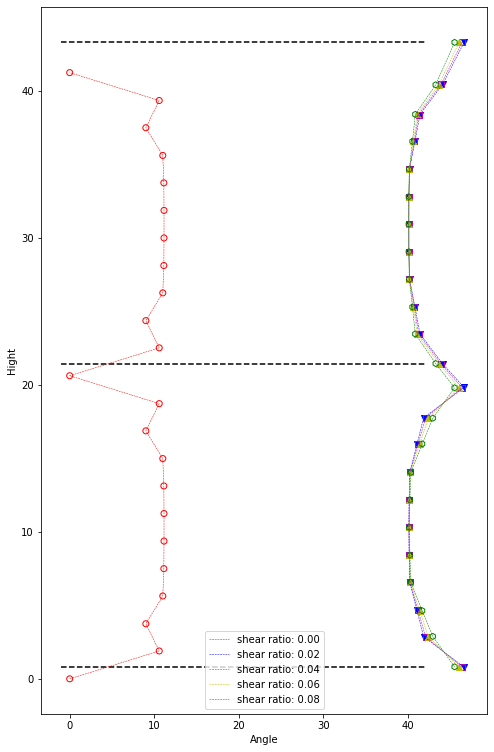

In [69]:
fig = twinboundary_shear_analyzer.plot_angle_diff()

## def plot_atom_diff

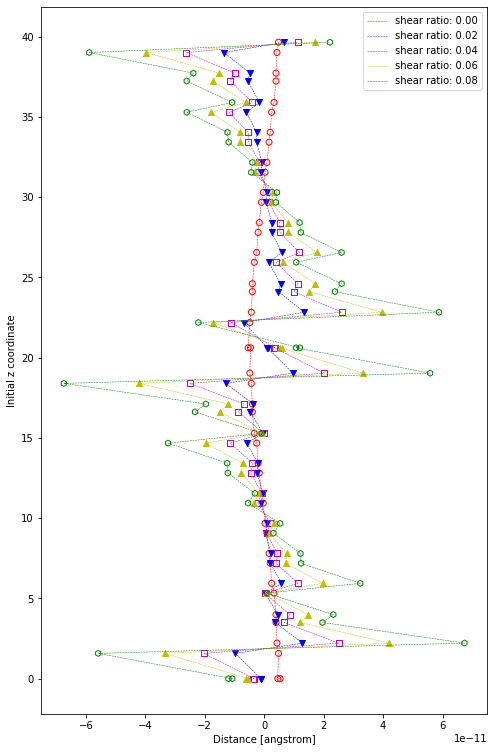

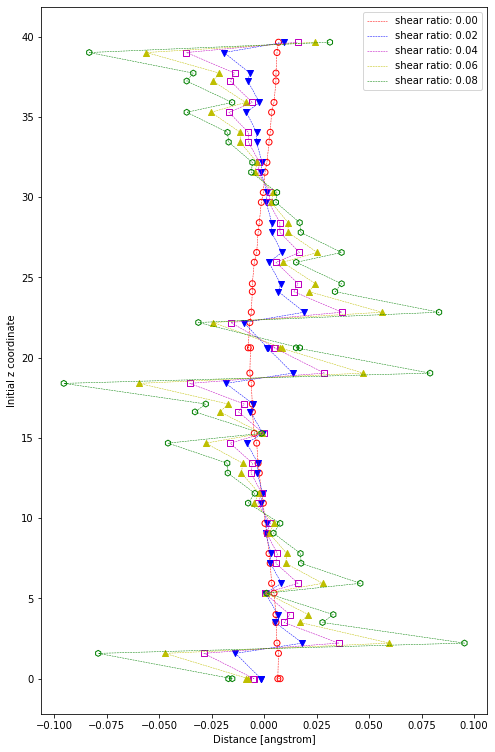

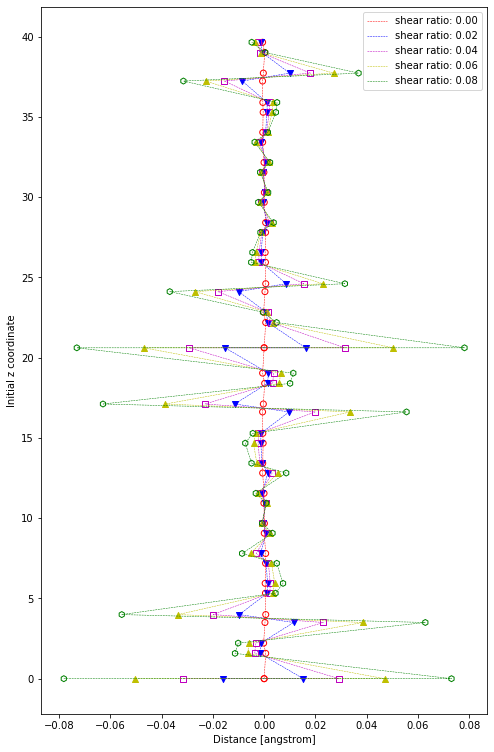

In [76]:
for direction in ['x', 'y', 'z']:
    fig = twinboundary_shear_analyzer.plot_atom_diff(
        direction=direction,
        shuffle=True)